In [1]:
import os,sys
import math

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from functools import reduce

import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold,cross_val_predict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

sys.path.append("../../src")  # adjust path as needed
from read_Parkinsonpredict import ReadData, LoadData
from ml_models import MlModels

#### Decision Trees!

0.9402859586706311 0.9852281360342515


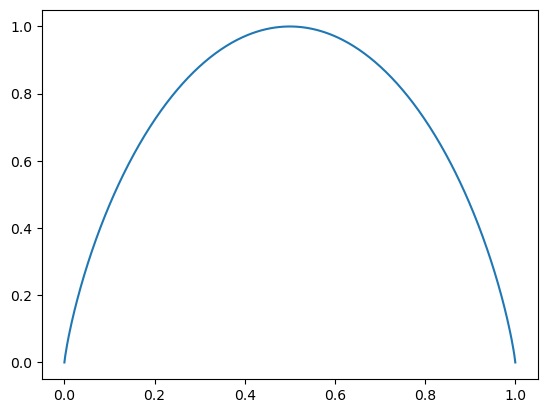

In [2]:
def entropy(p):
    return -(p*np.log2(p) + (1 - p) * np.log2(1 - p))

def gain(p, entropy):
    return entropy 
epsilon = 1e-10
p = np.linspace(0 + epsilon, 1 - epsilon, 500)
plt.plot(p, entropy(p))
print(entropy(9./14), entropy(3./7))

# Clinical Data

In [3]:
# --- Load data
mri_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/PDMRI_Clean_Merged_6_13_25.csv")
gene_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/gene_expression_summary.csv")
nhy_latest = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/clean_mds_updrs.csv")

clinical_data = gene_data[["PATNO", "EVENT_ID", "GENDER", "AGE", "EDUC_YRS"]]
gene_data_expressions = gene_data.drop(columns=["GENDER", "AGE", "EDUC_YRS"])

print(clinical_data.columns)

Index(['PATNO', 'EVENT_ID', 'GENDER', 'AGE', 'EDUC_YRS'], dtype='object')


In [4]:
clinical_data_bl = clinical_data[clinical_data["EVENT_ID"] == "BL"]
clinical_data_clean = clinical_data_bl[clinical_data_bl['AGE'].notna()]
data_clean = clinical_data_clean.merge(nhy_latest, how='inner', on=["PATNO"])
X_data = data_clean.drop(columns=['PATNO', 'EVENT_ID_x', 'EVENT_ID_y', 'NHY'])
X_data['GENDER'] = X_data['GENDER'].map({"Female": 1, "Male": 0})

Y_data = data_clean["NHY"].copy()
Y_data[Y_data == 0] = 0
Y_data[(Y_data == 1) | (Y_data == 2)] = 1
Y_data[Y_data > 2] = 2

print(Y_data.shape, X_data.shape)

(930,) (930, 3)


In [5]:
X_, X_test, Y_, Y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_, Y_, test_size=0.15, shuffle=True, random_state=42)

data = {}
data['X_train'] = X_train
data['Y_train'] = Y_train

In [6]:
params_xgb = {'max_depth':7, 'objective':'multi:softmax', 'num_class': 3}
my_model_boost = MlModels(model_name = 'xgboost', data=data, params = params_xgb, pca_flag=False, sample_weight=True)
mymodel_logistic = my_model_boost.build_model()

y_pred = my_model_boost.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 48.21%


# Clinical and MRI

In [4]:
# --- Load data
mri_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/PDMRI_Clean_Merged_6_13_25.csv")
gene_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/gene_expression_summary.csv")
nhy_latest = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/clean_mds_updrs.csv")

clinical_data = gene_data[["PATNO", "EVENT_ID", "GENDER", "AGE", "EDUC_YRS"]]
gene_data_expressions = gene_data.drop(columns=["GENDER", "AGE", "EDUC_YRS"])

print(clinical_data.columns)
clinical_data_bl = clinical_data[clinical_data["EVENT_ID"] == "BL"]
clinical_data_clean = clinical_data_bl[clinical_data_bl['AGE'].notna()]
data_clean = clinical_data_clean.merge(nhy_latest, how='inner', on=["PATNO"])

clinical_bl_clean = data_clean
mri_data_clean = mri_data.merge(clinical_bl_clean, how='inner', on=["PATNO"])
mri_drop_f = ["lh_MeanThickness", "lh_WhiteSurfArea", "rhCerebralWhiteMatterVol", "lhCerebralWhiteMatterVol"]
mri_drop_list = mri_drop_f + ["EVENT_ID_x", "EVENT_ID_y", "EVENT_ID", 'PATNO', "NHY"]
X_data_mri = mri_data_clean.drop(columns=["EVENT_ID_x", "EVENT_ID_y", "EVENT_ID", 'PATNO', "NHY"])

X_data_mri['GENDER'] = X_data_mri['GENDER'].map({"Female": 1, "Male": 0})
Y_data_mri = mri_data_clean["NHY"].copy()
Y_data_mri[Y_data_mri == 0] = 0
Y_data_mri[(Y_data_mri == 1) | (Y_data_mri == 2)] = 1
Y_data_mri[Y_data_mri > 2] = 2


Index(['PATNO', 'EVENT_ID', 'GENDER', 'AGE', 'EDUC_YRS'], dtype='object')


In [5]:
Xmri_, X_test_mri, Ymri_, Y_test_mri = train_test_split(X_data_mri, Y_data_mri, test_size=0.2, shuffle=True, random_state=42)
X_train_mri, X_cv_mri, Y_train_mri, Y_cv_mri = train_test_split(Xmri_, Ymri_, test_size=0.15, shuffle=True, random_state=42)

data_mri = {}
data_mri['X_train'] = X_train_mri
data_mri['Y_train'] = Y_train_mri

In [7]:
params_xgb = {'max_depth':6, 'objective':'multi:softmax', 'num_class': 3}
my_model_boost = MlModels(model_name = 'xgboost', data=data_mri, params = params_xgb, pca_flag=False, sample_weight=True)
mymodel_logistic = my_model_boost.build_model()

y_pred = my_model_boost.predict(X_cv_mri)
accuracy = accuracy_score(Y_cv_mri, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 42.86%


# All Data

### Load the Data

In [2]:
# --- Load data
mri_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/PDMRI_Clean_Merged_6_13_25.csv")
gene_data = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/gene_expression_summary.csv")
nhy_latest = pd.read_csv("/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/finalised_dataset/clean_mds_updrs.csv")

##### Baseline for Clinical Data

In [3]:
mri_data_bl  = mri_data.query("EVENT_ID == 'BL'")
gene_data_bl  = gene_data.query("EVENT_ID == 'BL'")
gene_data_bl = gene_data_bl[gene_data_bl["AGE"].notna()].copy()

gene_data_bl = gene_data_bl.rename(columns={"NHY": "NHY_BL"})

baseline_dfs = [mri_data_bl,gene_data_bl]

baseline_merged = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=["PATNO", "EVENT_ID"],   
        how="inner",                
        suffixes=("", "_dup")       
    ),
    baseline_dfs
)

baseline_merged = baseline_merged.drop(columns=["EVENT_ID"])
baseline_merged = baseline_merged.loc[:,~baseline_merged.columns.str.endswith("_dup")]
baseline_merged = baseline_merged.sort_values("PATNO").reset_index(drop=True)
baseline_merged["PATNO"] = baseline_merged["PATNO"].astype("Int64")

baseline_merged = baseline_merged.merge(nhy_latest,
                      how = 'left',
                      on = "PATNO",
                      suffixes=("", "_dup"))

baseline_merged = baseline_merged[baseline_merged["NHY"].notna() & (baseline_merged["NHY"] != 101)]

In [4]:
baseline_merged.columns

Index(['PATNO', 'MRIRSLT', 'lh_MeanThickness', 'rh_MeanThickness',
       'lh_WhiteSurfArea', 'rh_WhiteSurfArea', 'rhCerebralWhiteMatterVol',
       'lhCerebralWhiteMatterVol', 'Left_Cerebellum_White_Matter',
       'Right_Cerebellum_White_Matter',
       ...
       'ENSG00000261740', 'ENSG00000204577', 'ENSG00000213221',
       'ENSG00000166136', 'ENSG00000165983', 'ENSG00000254929',
       'ENSG00000135929', 'NHY_BL', 'EVENT_ID', 'NHY'],
      dtype='object', length=119)

In [5]:
mri_drop_f = ["lh_MeanThickness", "lh_WhiteSurfArea", "rhCerebralWhiteMatterVol", "lhCerebralWhiteMatterVol"]
mri_drop_list = mri_drop_f + ["EVENT_ID", "NHY_BL", "NHY", 'PATNO', 'MRIRSLT']
X_data = baseline_merged.drop(columns=mri_drop_list)

X_data['GENDER'] = X_data['GENDER'].map({"Female": 1, "Male": 0})
Y_data = baseline_merged["NHY"].copy()
Y_data[Y_data == 0] = 0
Y_data[(Y_data == 1) | (Y_data == 2)] = 1
Y_data[Y_data > 2] = 2

print(X_data.shape, Y_data.shape)

(639, 110) (639,)


In [6]:
X_data.columns

Index(['rh_MeanThickness', 'rh_WhiteSurfArea', 'Left_Cerebellum_White_Matter',
       'Right_Cerebellum_White_Matter', 'CerebralWhiteMatterVol',
       'rhSurfaceHoles', 'lhSurfaceHoles', 'GENDER', 'AGE', 'EDUC_YRS',
       ...
       'ENSG00000124279', 'ENSG00000064313', 'ENSG00000106443',
       'ENSG00000261740', 'ENSG00000204577', 'ENSG00000213221',
       'ENSG00000166136', 'ENSG00000165983', 'ENSG00000254929',
       'ENSG00000135929'],
      dtype='object', length=110)

In [7]:
X_, X_test, Y_, Y_test = train_test_split(X_data, Y_data, test_size=0.2, stratify=Y_data, shuffle=True, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_, Y_, test_size=0.15, stratify=Y_, shuffle=True, random_state=42)

data_mri = {}
data_mri['X_train'] = X_train
data_mri['Y_train'] = Y_train


In [9]:
params_xgb = {'max_depth':6, 'objective':'multi:softmax', 'num_class': 3}
my_model_boost = MlModels(model_name = 'xgboost', data=data_mri, params = params_xgb, pca_flag=False, sample_weight=True)
mymodel_logistic = my_model_boost.build_model()

y_pred = my_model_boost.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

my_model_boost1 = MlModels(model_name = 'xgboost', data=data_mri, params = params_xgb, pca_flag=False, sample_weight=False)
mymodel_logistic1 = my_model_boost1.build_model()

y_pred1 = my_model_boost1.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred1)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 53.25%
Accuracy: 54.55%


### With SMOTE

In [9]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, Y_train)
data = {}
data['X_train'] = X_train
data['Y_train'] = Y_train

In [10]:
params_xgb = {'max_depth':6, 'objective':'multi:softmax', 'num_class': 3}
my_model_boost = MlModels(model_name = 'xgboost', data=data, params = params_xgb, pca_flag=False, sample_weight=True)
mymodel_logistic = my_model_boost.build_model()

y_pred = my_model_boost.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

my_model_boost1 = MlModels(model_name = 'xgboost', data=data, params = params_xgb, pca_flag=False, sample_weight=False)
mymodel_logistic1 = my_model_boost1.build_model()

y_pred1 = my_model_boost1.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred1)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 53.25%
Accuracy: 54.55%


#### Regularization

In [9]:
params_xgb = {
    'max_depth': 6,
    'objective':'multi:softprob',
    'num_class': 3,
    'reg_alpha': 0.5,   # L1
    'reg_lambda': 1.0   # L2
}
my_model_boost = MlModels(model_name = 'xgboost', data=data_mri, params = params_xgb, pca_flag=False, sample_weight=True)
mymodel_logistic = my_model_boost.build_model()

y_pred = my_model_boost.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

my_model_boost1 = MlModels(model_name = 'xgboost', data=data_mri, params = params_xgb, pca_flag=False, sample_weight=False)
mymodel_logistic1 = my_model_boost1.build_model()

y_pred1 = my_model_boost1.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred1)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 51.95%
Accuracy: 54.55%


In [10]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_cv, y_pred))

[[20 14  0]
 [10 19  5]
 [ 2  6  1]]


In [11]:
from sklearn.metrics import classification_report
print(classification_report(Y_cv, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.625     0.588     0.606        34
         1.0      0.487     0.559     0.521        34
         2.0      0.167     0.111     0.133         9

    accuracy                          0.519        77
   macro avg      0.426     0.419     0.420        77
weighted avg      0.511     0.519     0.513        77



In [ ]:
data0 = Y_train[Y_train == 0]
data1 = Y_train[Y_train == 1]
data2 = Y_train[Y_train == 2]

w0 = len(data0)/ (len(data0) + len(data1) + len(data2))
w1 = len(data1)/ (len(data0) + len(data1) + len(data2))
w2 = len(data2)/ (len(data0) + len(data1) + len(data2))
class_weights = {0: w0, 1: w1, 2: w2}
params_xgb = {
    'max_depth': 3,
    'objective': 'multi:softprob',
    'num_class': 3,
    'reg_alpha': 0.5,   # L1
    'reg_lambda': 1.0   # L2
}

my_model_boost = MlModels(
    model_name='xgboost',
    data=data_mri,
    params=params_xgb,
    pca_flag=False,
    class_weights=class_weights
)
my_model_boost = MlModels(model_name = 'xgboost', data=data_mri, params = params_xgb, pca_flag=False, sample_weight=True)
mymodel_logistic = my_model_boost.build_model()

y_pred = my_model_boost.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

from sklearn.metrics import classification_report
print(classification_report(Y_cv, y_pred, digits=3))

Accuracy: 46.75%
              precision    recall  f1-score   support

         0.0      0.486     0.545     0.514        33
         1.0      0.471     0.471     0.471        34
         2.0      0.333     0.200     0.250        10

    accuracy                          0.468        77
   macro avg      0.430     0.405     0.412        77
weighted avg      0.460     0.468     0.461        77



In [11]:
from sklearn.utils.class_weight import compute_sample_weight

# 1. Define parameter grid
param_grid = {
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 150],
    "subsample": [0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0.5, 1.0, 2.0]
}

# 2. Instantiate base XGBoost model
xgb = XGBClassifier(
    use_label_encoder=False,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss'
)

# 3. Compute sample weights
sample_weight = compute_sample_weight(class_weight='balanced', y=Y_)

# 4. Grid search with sample_weight
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',  # or 'accuracy'
    verbose=1,
    n_jobs=-1
)

# 5. Fit with sample_weight
grid_search.fit(X_, Y_, sample_weight=sample_weight)

# 6. Report results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (macro F1):", grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:51:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:51:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:51:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/x

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 1.0}
Best Score (macro F1): 0.41963566155481385


### Best Parameters

In [8]:
data0 = Y_train[Y_train == 0]
data1 = Y_train[Y_train == 1]
data2 = Y_train[Y_train == 2]

w0 = len(data0)/ (len(data0) + len(data1) + len(data2))
w1 = len(data1)/ (len(data0) + len(data1) + len(data2))
w2 = len(data2)/ (len(data0) + len(data1) + len(data2))
class_weights = {0: w0, 1: w1, 2: w2}
params_xgb = {
    'max_depth': 6,
    'n_estimators': 100,
    'objective': 'multi:softprob',
    'num_class': 3,
    'reg_alpha': 0.5,   # L1
    'reg_lambda': 1.0,   # L2
    'learning_rate': 0.1,
    'subsample': 1.0
}

# my_model_boost2 = MlModels(
#     model_name='xgboost',
#     data=data_mri,
#     params=params_xgb,
#     pca_flag=False,
#     class_weights=class_weights
# )

my_model_boost2 = MlModels(
    model_name='xgboost',
    data=data_mri,
    params=params_xgb,
    pca_flag=False,
    sample_weight=True
)

# my_model_boost1 = MlModels(model_name = 'xgboost', data=data_mri, params = params_xgb, pca_flag=False, sample_weight=True)
mymodel_logistic2 = my_model_boost2.build_model()

y_pred = my_model_boost2.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

from sklearn.metrics import classification_report
print(classification_report(Y_cv, y_pred, digits=3))

Accuracy: 46.75%
              precision    recall  f1-score   support

         0.0      0.516     0.485     0.500        33
         1.0      0.500     0.588     0.541        34
         2.0      0.000     0.000     0.000        10

    accuracy                          0.468        77
   macro avg      0.339     0.358     0.347        77
weighted avg      0.442     0.468     0.453        77



In [10]:
print(mymodel_logistic.get_xgb_params())

{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'num_class': 3}


In [ ]:
param_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8], 
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 150, 200],
    "subsample": [0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1],   # L1 regularization
    "reg_lambda": [0.5, 1.0, 2.0]    # L2 regularization
}
xgb = XGBClassifier(use_label_encoder=False,objective='multi:softmax', num_class = 3, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_, Y_)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:19:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:19:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:19:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/x

KeyboardInterrupt: 